# Information Bottleneck theory for Deep Learning

This is a demonstration of the information bottleneck theory for deep learning, introduced by Naftali Tishby. Here I tried to reproduce the main results in their recent paper [Opening the black box of Deep Neural Networks via Information](https://arxiv.org/pdf/1703.00810.pdf).

In [2]:
import numpy as np
from random import randint, seed
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML
from scipy.ndimage.filters import gaussian_filter

print(animation.writers.list())

[u'imagemagick_file', u'imagemagick', u'ffmpeg', u'ffmpeg_file', u'html', u'pillow']


## Data generation

First, we will generate a very simple dataset for the demonstration. The inputs are vectors of n_bits = 10

In [3]:
def generate_samples(n_samples, n_bits):
    # Genera vectores binarios que representan numeros entre 
    # 0 y 2**n_bits-1
    
    # X_data = Y_data para autoencoders
    x_data = np.random.randint(2, size=(n_samples,n_bits))
    o = np.ones(n_samples).reshape((n_samples,1))
    y = np.linspace(n_bits-1,0,n_bits).reshape((1,n_bits))
    x = np.dot(o,y)
    x_int = np.sum(x_data*2**(x_data*x), axis = 1, dtype = int)
    y_data = x_data
    return x_data, y_data, x_int


n_train_samples = 50000 # number of train samples
n_test_samples = 10000 # number of test samples
n_bits = 10

x_train, y_train, x_train_int = generate_samples(n_train_samples, n_bits)
x_test, y_test, _ = generate_samples(n_test_samples, n_bits)



## Neural network

Then we are going to build a fully-connected neural network Autoencoder with 5 hidden layers, which have 8, 6, 4, 6 and 8 neurons respectively. First let's define a fully-connected layer and a output layer using Tensorflow:

In [6]:
def get_weights(hidden_layers, n_bits):
    assert len(hidden_layers)==5
    n1, n2, n3, n4, n5 = hidden_layers
    n_output = n_bits

    weights_ = {
        'ce1': tf.Variable(tf.random_normal([n_bits, n1],  stddev=0.1)),
        'ce2': tf.Variable(tf.random_normal([n1, n2], stddev=0.1)),
        'ce3': tf.Variable(tf.random_normal([n2, n3], stddev=0.1)),
        'cd3': tf.Variable(tf.random_normal([n3, n4], stddev=0.1)),
        'cd2': tf.Variable(tf.random_normal([n4, n5], stddev=0.1)),
        'out': tf.Variable(tf.random_normal([n5, n_output] , stddev=0.1)),
    }
    biases_ = {
        'be1': tf.Variable(tf.random_normal([n1], stddev=0.1)),
        'be2': tf.Variable(tf.random_normal([n2], stddev=0.1)),
        'be3': tf.Variable(tf.random_normal([n3], stddev=0.1)),
        'bd3': tf.Variable(tf.random_normal([n2], stddev=0.1)),
        'bd2': tf.Variable(tf.random_normal([n1], stddev=0.1)),
        'out': tf.Variable(tf.random_normal([n_output], stddev=0.1))
    }
    return weights_, biases_

In [7]:
def cae(_X, _W, _b, _keepprob):
    # Encoder
    _ce1 = tf.nn.tanh(tf.add(tf.matmul(_X  , _W['ce1']), _b['be1'])) 
    _ce2 = tf.nn.tanh(tf.add(tf.matmul(_ce1, _W['ce2']), _b['be2'])) 
    _ce3 = tf.nn.tanh(tf.add(tf.matmul(_ce2, _W['ce3']), _b['be3'])) 
    # Decoder
    _cd3 = tf.nn.tanh(tf.add(tf.matmul(_ce3, _W['cd3']), _b['bd3'])) 
    _cd2 = tf.nn.tanh(tf.add(tf.matmul(_cd3, _W['cd2']), _b['bd2'])) 
    _out = tf.nn.sigmoid(tf.add(tf.matmul(_cd2, _W['out']), _b['out'])) 
    
    return {'ce1': _ce1, 'ce2': _ce2, 'ce3': _ce3
            , 'layers': (_X, _ce1, _ce2, _ce3, _cd3, _cd2, _out)
        , 'out': _out}
print ("Network ready")

Network ready


In [8]:
def build_network(hidden_layers = [8,6,4,6,8], n_bits = 10):
    global x, y, logits, layers, cost, optimizer, accuracy, out, weights, biases
    global ce1,ce2,ce3,cd3,cd2,out_l,in8,in6,in4
    tf.reset_default_graph()
    tf.set_random_seed(12345)
    
    keepprob = tf.placeholder(tf.float32)
    weights, biases = get_weights(hidden_layers, n_bits)
    
    # input and output of the Autoencoder
    x = tf.placeholder(tf.float32, [None, n_bits], name = 'x')
    y = tf.placeholder(tf.float32, [None, n_bits], name = 'y')
    
    # inputs of the intermediate layers
    in8 = tf.placeholder(tf.float32, [None, hidden_layers[0]], name = 'in8')
    in6 = tf.placeholder(tf.float32, [None, hidden_layers[1]], name = 'in6')
    in4 = tf.placeholder(tf.float32, [None, hidden_layers[2]], name = 'in4')
    
    # intermediate layers:
    #     Encoder
    ce1 = tf.nn.tanh(tf.add(tf.matmul(x  , weights['ce1']), biases['be1'])) 
    ce2 = tf.nn.tanh(tf.add(tf.matmul(in8, weights['ce2']), biases['be2'])) 
    ce3 = tf.nn.tanh(tf.add(tf.matmul(in6, weights['ce3']), biases['be3'])) 
    #     Decoder
    cd3 = tf.nn.tanh(tf.add(tf.matmul(in4, weights['cd3']), biases['bd3'])) 
    cd2 = tf.nn.tanh(tf.add(tf.matmul(in6, weights['cd2']), biases['bd2'])) 
    out_l = tf.nn.sigmoid(tf.add(tf.matmul(in8, weights['out']), biases['out'])) 
    

    logits = cae(x, weights, biases, keepprob)['out']
    layers = cae(x, weights, biases, keepprob)['layers']
    cost = tf.reduce_sum(tf.square(logits - y))
    
    learning_rate = 0.001
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    out = tf.cast(logits>0.5,dtype = tf.float32)
    correct_predictions = tf.equal(out, y)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
    print ("Functions ready")

def print_out_summary(sess, epoch):
    acc, loss, y_pred, y_out = sess.run([accuracy, cost, logits, out], feed_dict={x: x_test, y: x_test})
    print('Epoch {:>4}:  Testing accuracy {:>.4f} - Testing loss {:>.4f}'.format(epoch, acc, loss))



Let's first train the network without calculating the mutual information to make sure we have the correct results.


In [9]:
n_bits = 10
n_epochs = 3000
x_train, y_train, x_train_int = generate_samples(n_train_samples, n_bits)
x_test, y_test, _ = generate_samples(n_test_samples, n_bits)
hidden_layers = [8,6,4,6,8]
build_network(hidden_layers, n_bits) 
print(x_train.shape, y_train.shape)
ACC = []; LOSS = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer()) # initialization
    for epoch in range(n_epochs):
        x_train, y_train, x_train_int = generate_samples(n_train_samples, n_bits)
        _, acc, lss = sess.run([optimizer, accuracy, cost], feed_dict={x: x_train, y: x_train})
        if epoch % 100 == 0:   print_out_summary(sess, epoch)
        if epoch % 20 == 0:
            ACC.append(acc); LOSS.append(lss)
        if acc==1:
            break
        

Functions ready
((50000, 10), (50000, 10))
Epoch    0:  Testing accuracy 0.5015 - Testing loss 25031.9102
Epoch  100:  Testing accuracy 0.6235 - Testing loss 23697.1211
Epoch  200:  Testing accuracy 0.6219 - Testing loss 22689.5195
Epoch  300:  Testing accuracy 0.6223 - Testing loss 22615.8633
Epoch  400:  Testing accuracy 0.6227 - Testing loss 22583.8125
Epoch  500:  Testing accuracy 0.6221 - Testing loss 22566.1152
Epoch  600:  Testing accuracy 0.6234 - Testing loss 22553.2695
Epoch  700:  Testing accuracy 0.6250 - Testing loss 22523.4629
Epoch  800:  Testing accuracy 0.6757 - Testing loss 20581.8066
Epoch  900:  Testing accuracy 0.6782 - Testing loss 20226.8809
Epoch 1000:  Testing accuracy 0.6804 - Testing loss 20119.9785
Epoch 1100:  Testing accuracy 0.6855 - Testing loss 19999.5000
Epoch 1200:  Testing accuracy 0.6880 - Testing loss 19772.3691
Epoch 1300:  Testing accuracy 0.7269 - Testing loss 17772.7969
Epoch 1400:  Testing accuracy 0.7361 - Testing loss 17217.1445
Epoch 1500: 

Let's see the accuracy and loss evolution during training

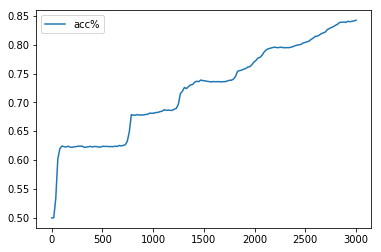

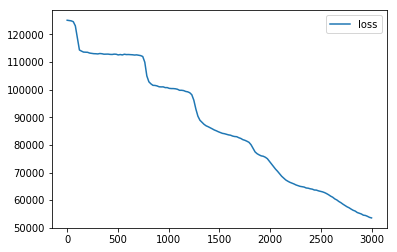

In [10]:
ep = np.linspace(0,n_epochs, len(ACC))
plt.plot(ep,ACC, label='acc%')
plt.legend()
plt.show()
plt.plot(ep,LOSS, label='loss')
plt.legend()
plt.show()

## Mutual information

Now we are ready to explore the information bottleneck theory for our network. To estimate the mutual information between all the hidden layers and intput/output layers, we could binned the output activations as stated in the paper  (here we choose 30 bins, the same as in the paper), so that the hidden layer random variables $T_i$ (each $i$ corresponds to one hidden layer) would be discrete. Then, we will be able to estimate the joint distribution $P(X,T_i)$ and $P(T_i,Y)$, and use them to calculate the encoder mutual information (between input $X$ and hidden layer $T_i$)
\begin{equation}
    I(X;T_i) = \sum_{x\in X, t\in T_i}P(x,t)\log\Big(\frac{P(x,t)}{P(x)P(t)}\Big)
\end{equation}

and decoder mutual information (between hidden layer $T_i$ and desired output $Y$, note that it is not the model output $\widehat{Y}$)
\begin{equation}
    I(T_i;Y) = \sum_{t\in T_i, y\in Y}P(t,y)\log\Big(\frac{P(t,y)}{P(t)P(y)}\Big).
\end{equation}

Actually we use the property of mutual information:
\begin{equation}
    I(T_i;X) = H(T_i) - H(T_i|X) = H(T_i) = -\sum_{t\in T_i}P(t)\log P(t).
\end{equation}

In [14]:
from collections import Counter

def create_tensors(nbins, shape):
    '''Generate a tensor of a given shape (for a intermediate layer).
    The values are calculated dividing the space between -1 and 1 in nbins, and
    the values are generated randomly in only one cell
    '''
    bins_x = np.linspace(-1,1,nbins+1)
    base_num = bins_x[int(len(bins_x)/2)] + 1./nbins
    base_tensor = base_num*np.ones(shape, dtype=np.float32)
    generated_tensor = np.array(base_tensor + 
                base_num*(1 - 2*np.random.random_sample(base_tensor.shape))/2., dtype=np.float32)
    indices_x = np.digitize(generated_tensor, bins_x)
    return base_tensor, generated_tensor

def log(x):
    z = (x==0)*1
    return np.log(x + z)/np.log(2)

def calc_mutual_information(hidden, x_train_int, n_bins):
    n_neurons = hidden.shape[1]
    
    # discretization 
    bins = np.linspace(-1, 1, n_bins+1)
    indices = np.digitize(hidden, bins)
    n_train_samples_ = len(hidden)
    # initialize pdfs
    pdf_x = Counter(); pdf_y = Counter(); pdf_t = Counter(); pdf_xt = Counter(); pdf_yt = Counter()

    for i in range(n_train_samples_):
        pdf_x[x_train_int[i]] += 1./float(n_train_samples_) 
        #pdf_y[y_train[i,0]] += 1/float(n_train_samples)      
        pdf_xt[(x_train_int[i],)+tuple(indices[i,:])] += 1./float(n_train_samples_) 
        #pdf_yt[(y_train[i,0],)+tuple(indices[i,:])] += 1/float(n_train_samples)
        pdf_t[tuple(indices[i,:])] += 1./float(n_train_samples_)
    assert len(pdf_x)==len(pdf_xt)
    assert len(pdf_x)>=len(pdf_t)
    # calcuate encoder mutual information I(X;T)
    mi_xt = 0
    h_x = 0
    h_t_x = 0
    for i in pdf_xt:
        # P(x,t), P(x) and P(t)
        p_xt = pdf_xt[i]; p_x = pdf_x[i[0]]; p_t = pdf_t[i[1:]]
        # I(X;T)
        mi_xt += p_xt * log(p_xt /(p_x * p_t))
        h_t_x -= p_xt * log(p_xt/p_x)
        
    for i in pdf_x:
        p_x = pdf_x[i]
        h_x -= p_x*log(p_x)
 
    # calculate decoder mutual information I(T;Y)
    h_t = 0
    for i in pdf_t:
        # P(t,y), P(t) and P(y)
        p_t = pdf_t[i]
        # I(X;T)
        h_t -= p_t*log(p_t)
    #print('I(X;T) = H(T) - H(T|X)')
    #print(mi_xt,"=",h_t,"-",h_t_x)
    return max(0, mi_xt)

def calc_mutual_information_v2(hidden, x_train_int, n_bins = 30):
    # discretization 
    bins = np.linspace(-1, 1, n_bins+1)
    indices = np.digitize(hidden, bins)
    n_train_samples_ = len(hidden)
    
    # initialize pdf
    pdf_t = Counter()
    for i in range(n_train_samples_):
        pdf_t[tuple(indices[i,:])] += 1./float(n_train_samples_) 
        
    h_t = 0
    for i in pdf_t:
        # P(t)
        p_t = pdf_t[i]
        # I(X;T) = H(T)
        h_t -= p_t*log(p_t)
    h_t = max(h_t, 0)
    return h_t

def calc_mutual_information_v3(hidden, x_train, n_bins):
    state_dict = {}
    n_samples = float(len(hidden))
    for N in hidden:
        try:
            state_dict[tuple(N)] += 1./n_samples
        except KeyError:
            state_dict[tuple(N)] = 1./n_samples
    H = 0
    for state, p in state_dict.items():
        H -= p*log(p)
    H = max(H,0)
    return H
    

# get mutual information for all hidden layers
def get_mutual_information(hiddens, x_train_int, bins = 30):
    mi_xt_list = []
    for k, hidden in enumerate(hiddens):
        N, n = hidden.shape
        mi_xt = calc_mutual_information_v2(hidden, x_train_int, bins)
        mi_xt_list.append(mi_xt)
    #    print n_cells_t,
    #print ''
    return mi_xt_list

In [18]:
# train the neural network and obtain mutual information
def train_with_mi(n_epochs, hidden_layers, n_bits = 10, n_bins = 30):
    build_network(hidden_layers, n_bits)
    mi_xt_all = []; epochs = []; mi_err = []; Acc = []
    layer_names = [ce1, ce2, ce3, cd3, cd2, out_l]
    inputs = [x, in8, in6, in4, in6, in8]
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer()) # initialization
    
        for epoch in range(n_epochs):
            x_train, y_train, x_train_int = generate_samples(n_train_samples, n_bits)
            sess.run(optimizer, feed_dict={x: x_train, y: x_train})
                        
            if epoch % 500 == 0: print_out_summary(sess, epoch)
                
            if epoch % 40 == 0:       
                x_train, y_train, x_train_int = generate_samples(n_test_samples, n_bits)
                hidden_layers, acc = sess.run([layers, accuracy], feed_dict={x: x_train, y: x_train})
                                
                mi_xt = get_mutual_information(hidden_layers[1:], x_train_int, n_bins)
                mi_xt_all.append(mi_xt)
                epochs.append(epoch)
                Acc.append(acc)
                
                h_ = []
                for k, hidd in enumerate(hidden_layers[:-1]):
                    base_t, gen_t = create_tensors(n_bins,hidd.shape)
                    base_fc = sess.run(layer_names[k], feed_dict={inputs[k]: base_t})
                    gen_fc  = sess.run(layer_names[k], feed_dict={inputs[k]: gen_t})
                    h_fc_gen = calc_mutual_information_v2(gen_fc, 0, n_bins = n_bins)
                    h_.append(h_fc_gen)
                mi_err.append(h_)
    
    return np.array(mi_xt_all), np.array(epochs), np.array(mi_err), hidden_layers, np.array(Acc)

n_bits = 10
n_epochs = 5001
n_bins = 10
hidden_layers = [8,6,4,6,8]
n_train_samples = 2000
mi_xt_all, epochs, mi_err, hiddens, Acc10 = train_with_mi(n_epochs, hidden_layers, n_bits, n_bins)

Functions ready
Epoch    0:  Testing accuracy 0.4983 - Testing loss 25043.1328
Epoch  500:  Testing accuracy 0.6227 - Testing loss 22558.1328
Epoch 1000:  Testing accuracy 0.6786 - Testing loss 20172.5977
Epoch 1500:  Testing accuracy 0.6911 - Testing loss 19440.4570
Epoch 2000:  Testing accuracy 0.7175 - Testing loss 17527.2559
Epoch 2500:  Testing accuracy 0.7352 - Testing loss 16469.2949
Epoch 3000:  Testing accuracy 0.7636 - Testing loss 15272.6250
Epoch 3500:  Testing accuracy 0.7862 - Testing loss 13738.9863
Epoch 4000:  Testing accuracy 0.7880 - Testing loss 13218.4570
Epoch 4500:  Testing accuracy 0.7924 - Testing loss 12811.8633
Epoch 5000:  Testing accuracy 0.8012 - Testing loss 12511.3682


## Visualization

Below is a movie showing the evolution of the hidden layers with the training epochs in the information plane. We can clearly see two distinct optimization phases in the information plane, as discussed in the paper. During the first *empirical error minimization* (ERM) phase (until around epoch 1500), the information on the outputs $I_Y$ increases quickly, and then during the second *representation compression* phase (from around epoch 1500 onwards), the information on the inputs $I_X$ decreases. The evolution is not as smooth as shown in the paper, because it is the result of only one network, instead of average of multiple networks. 

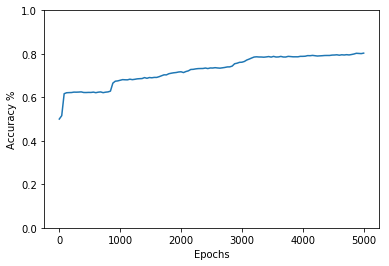

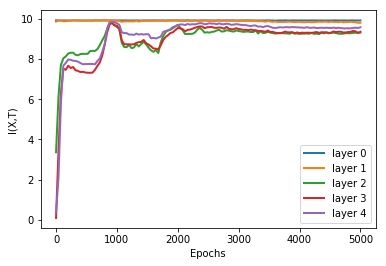

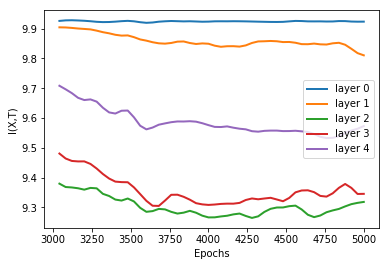

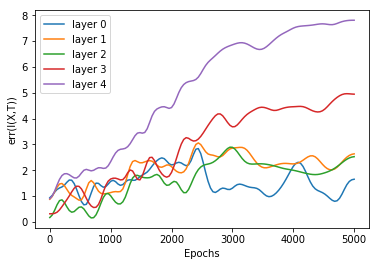

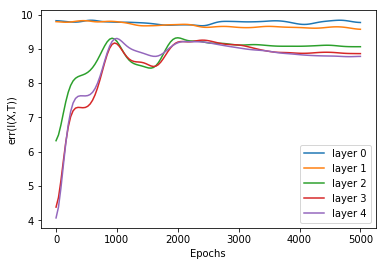

In [57]:
save = True
plt.plot(epochs, Acc10)
plt.xlabel("Epochs")
plt.ylabel('Accuracy %')
plt.ylim([0,1])
if save:
    plt.savefig("/home/daniel/teo_info/imagenes/acc_bins_%d"%n_bins, dpi = 200, papertype = 'ledger')
plt.show()

for i in range(len(hiddens)-2):   
    plt.plot(epochs, gaussian_filter(mi_xt_all[:,i], sigma=0), label='layer '+str(i),
            linewidth = 2)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("I(X,T)")
if save:
    plt.savefig("/home/daniel/teo_info/imagenes/general_bins_%d"%n_bins, dpi = 200, papertype = 'ledger')
plt.show()

for i in range(len(hiddens)-2):   
    plt.plot(epochs[-50:], gaussian_filter(mi_xt_all[:,i], sigma=1)[-50:], label='layer '+str(i),
            linewidth = 2)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("I(X,T)")
if save:
    plt.savefig("/home/daniel/teo_info/imagenes/zoom_bins_%d"%n_bins, dpi = 200, papertype = 'ledger')
plt.show()

#f =  np.ones((19))/19.
for i in range(len(hiddens)-2):   
    plt.plot(epochs, gaussian_filter(mi_err[:,i], sigma=2), label='layer '+str(i))
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("err(I(X,T))")
if save:
    plt.savefig("/home/daniel/teo_info/imagenes/dispersion_bins_%d"%n_bins, dpi = 200, papertype = 'ledger')
plt.show()

for i in range(len(hiddens)-2):   
    plt.plot(epochs, gaussian_filter(mi_xt_all[:,i]-mi_err[:,i]/10, sigma=3), label='layer '+str(i))
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("err(I(X,T))")

plt.show()

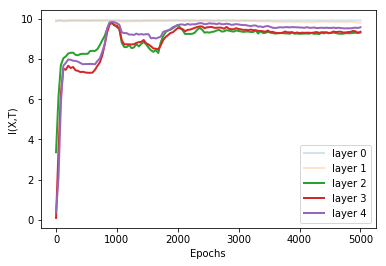

In [63]:
nl = [2,3,4]
save=True
for i in range(len(hiddens)-2):   
    if i in nl: alpha_=1
    else: alpha_=0.2
    plt.plot(epochs, gaussian_filter(mi_xt_all[:,i], sigma=0), label='layer '+str(i),alpha=alpha_,
            linewidth = 2)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("I(X,T)")
if save:
    plt.savefig("/home/daniel/teo_info/imagenes/bins_"+str(n_bins)+"_"+str(tuple(nl)), dpi = 200, papertype = 'ledger')
plt.show()